# CITS4012 Project 1 (Sem1 2022)
# Ankit Kamboj
# 23372936

#### To run the chatbot, run all cells in the jupyter notebook. The last cell activates the chatbot. Once the last cell is active, then send message via telegram /start

#### Chatbotname: SeekDoge

# 1.0 Data Exploration

## 1.1 Frequency of job categories by city

In [104]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import nltk
import spacy
from spacy.tokens import DocBin
from spacy import displacy
from nltk.stem.porter import *
from spacy.matcher import Matcher
from spacy.matcher import DependencyMatcher
from spacy.matcher import PhraseMatcher
from spacy import load
import numerizer
import re
import swifter
import pickle
import telegram
from telegram.ext import Updater, MessageHandler, Filters
import time
from telegram import Update
from telegram.ext import (
    Updater,
    CommandHandler,
    MessageHandler,
    Filters,
    CallbackContext,
)


In [105]:
data = pd.read_csv('seek_australia.csv')

In [106]:
data.head(2)

,category,city,company_name,geo,job_board,job_description,job_title,job_type,post_date,salary_offered,state,url
0,Retail & Consumer Products,Sydney,Frontline Executive Retail Sydney,AU,seek,Have you had 10 years experience in fresh pro...,Store Manager - Fresh Produce,Full Time,2018-04-15T23:13:45Z,$100k Base + Super + Benefits,North Shore & Northern Beaches,https://www.seek.com.au/job/35989382
1,Government & Defence,Brisbane,Powerlink,AU,seek,The Opportunity: The Client Solution Analyst ...,Client Solution Analyst,Full Time,2018-04-15T23:04:40Z,Excellent remuneration packages,Northern Suburbs,https://www.seek.com.au/job/35989272


In [107]:
data.loc[:,'category':'city']

,category,city
0,Retail & Consumer Products,Sydney
1,Government & Defence,Brisbane
2,Trades & Services,Sydney
3,Trades & Services,Melbourne
4,Trades & Services,Adelaide
...,...,...
29995,Hospitality & Tourism,Sydney
29996,CEO & General Management,ACT
29997,Accounting,Melbourne
29998,Government & Defence,ACT


In [108]:
unique_jobcats_by_city = data.loc[:,'category':'city'].groupby(['city', 'category'], as_index=False).size().sort_values(['city', 'size'], ascending=[True, False], ignore_index=True)
unique_jobcats_by_city.rename(columns={'size':'num_jobs'}, inplace=True)
unique_jobcats_by_city

,city,category,num_jobs
0,ACT,Information & Communication Technology,196
1,ACT,Government & Defence,145
2,ACT,Trades & Services,60
3,ACT,Administration & Office Support,54
4,ACT,Healthcare & Medical,51
...,...,...,...
1171,Yorke Peninsula & Clare Valley,Engineering,1
1172,Yorke Peninsula & Clare Valley,Government & Defence,1
1173,Yorke Peninsula & Clare Valley,Retail & Consumer Products,1
1174,Yorke Peninsula & Clare Valley,Sales,1


In [109]:
# Top job categories by city

top_jobcats = unique_jobcats_by_city.sort_values(['num_jobs'], ascending=[False], ignore_index=True).groupby(['city']).apply(lambda x:x)
top_jobcats

,city,category,num_jobs
0,Sydney,Information & Communication Technology,1243
1,Melbourne,Trades & Services,810
2,Melbourne,Information & Communication Technology,746
3,Sydney,Trades & Services,719
4,Sydney,"Manufacturing, Transport & Logistics",698
...,...,...,...
1171,Hervey Bay & Fraser Coast,Accounting,1
1172,Somerset & Lockyer,Retail & Consumer Products,1
1173,Somerset & Lockyer,Government & Defence,1
1174,Somerset & Lockyer,Accounting,1


In [110]:
# Top 5 cities with the most jobs

top_jobcats['cumnum_jobs'] = top_jobcats.groupby(['city'])['num_jobs'].apply(lambda x: x.cumsum())
cities_with_most_jobs = top_jobcats[top_jobcats.columns.drop(['num_jobs','category'])].sort_values('cumnum_jobs', ascending=False).drop_duplicates(subset='city', keep='first', ignore_index=True)
cities_with_most_jobs.head(5)

,city,cumnum_jobs
0,Sydney,9412
1,Melbourne,7361
2,Brisbane,2951
3,Perth,2026
4,Adelaide,1195


In [111]:
# Top 5 cities with the most jobs as a list

top5cities_most_jobs = list(cities_with_most_jobs.head(5)['city'])
top5cities_most_jobs

['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide']

In [112]:
# Get data of the top 5 cities with most jobs

top5cities_data = top_jobcats[np.isin(top_jobcats['city'].to_numpy(), top5cities_most_jobs)].reset_index(drop=True)[['city', 'category', 'num_jobs']]

In [113]:
top5cities_data

,city,category,num_jobs
0,Sydney,Information & Communication Technology,1243
1,Melbourne,Trades & Services,810
2,Melbourne,Information & Communication Technology,746
3,Sydney,Trades & Services,719
4,Sydney,"Manufacturing, Transport & Logistics",698
...,...,...,...
144,Perth,"Farming, Animals & Conservation",3
145,Adelaide,"Farming, Animals & Conservation",3
146,Perth,Self Employment,2
147,Brisbane,Self Employment,1


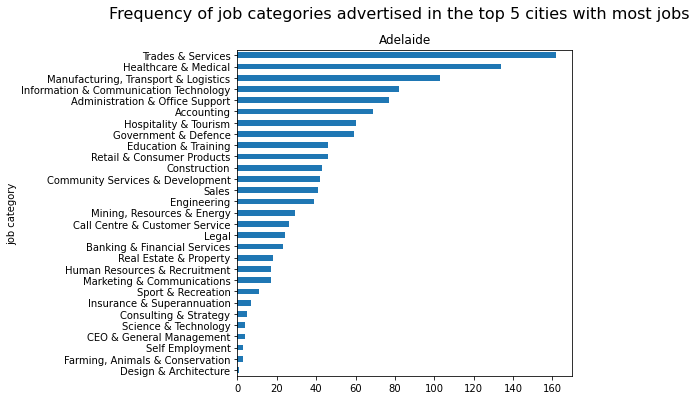

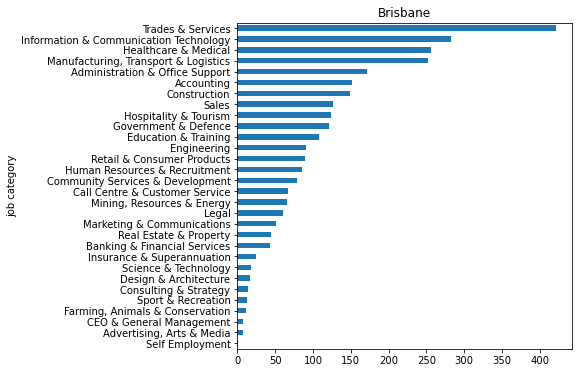

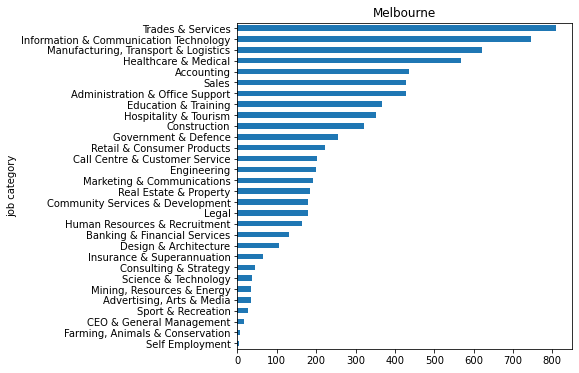

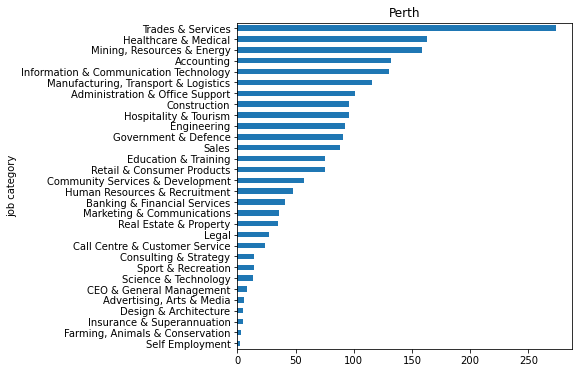

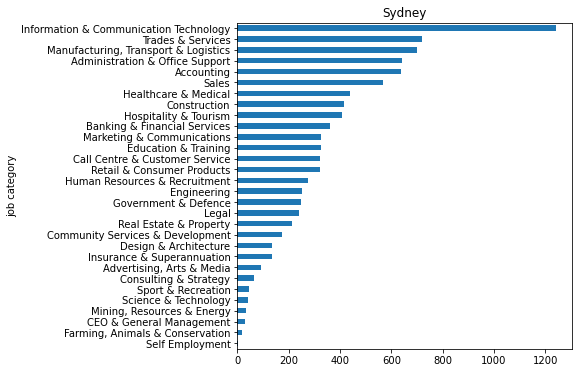

In [114]:
addMainTitle = True
for title, group in top5cities_data.groupby('city'):
    ax = group.plot.barh(x='category', figsize=(6,6), subplots=False, legend=False, xlabel='job category', title=title)
    ax.invert_yaxis() # to show y-axis in descending order
    if(addMainTitle==True): # to show the main title above first figure only
        plt.suptitle('Frequency of job categories advertised in the top 5 cities with most jobs', fontsize=16)
        addMainTitle = False
    


## 1.2 Vocabulary of each category

In [115]:
job_cats_and_desc_df = data[['category','job_description']].drop_duplicates(ignore_index=True)
job_cats_unique_list = set(job_cats_and_desc_df['category'].tolist())
print(f"There are {len(job_cats_unique_list)} unique job categories:\n")
print(job_cats_unique_list)
job_cats_and_desc_df

There are 30 unique job categories:

{'CEO & General Management', 'Sales', 'Human Resources & Recruitment', 'Advertising, Arts & Media', 'Government & Defence', 'Trades & Services', 'Construction', 'Administration & Office Support', 'Call Centre & Customer Service', 'Education & Training', 'Science & Technology', 'Community Services & Development', 'Farming, Animals & Conservation', 'Manufacturing, Transport & Logistics', 'Real Estate & Property', 'Marketing & Communications', 'Healthcare & Medical', 'Mining, Resources & Energy', 'Design & Architecture', 'Insurance & Superannuation', 'Self Employment', 'Sport & Recreation', 'Information & Communication Technology', 'Hospitality & Tourism', 'Engineering', 'Retail & Consumer Products', 'Legal', 'Accounting', 'Banking & Financial Services', 'Consulting & Strategy'}


,category,job_description
0,Retail & Consumer Products,Have you had 10 years experience in fresh pro...
1,Government & Defence,The Opportunity: The Client Solution Analyst ...
2,Trades & Services,An innovative business development role for a...
3,Trades & Services,About the role: We are seeking an Automotive W...
4,Trades & Services,Â Early starts and weekend shifts. No experie...
...,...,...
27937,Hospitality & Tourism,Hotel snapshot The Radisson Blu Plaza Sydney ...
27938,CEO & General Management,The Organisation Airservices is a government ...
27939,Accounting,ABOUT THE COMPANY AND ROLE Our client is one o...
27940,Government & Defence,Long term contract for 12 months with possibl...


In [116]:
job_cats_and_desc_df['tokenized_cat'] = job_cats_and_desc_df.category.apply(lambda x: nltk.RegexpTokenizer(r'\w+').tokenize(x))
job_cats_and_desc_df['vocab_size'] = job_cats_and_desc_df.tokenized_cat.apply(lambda x: len(x))

print("Vocabulary of each job category: \n")
job_cats_and_desc_df

Vocabulary of each job category: 



,category,job_description,tokenized_cat,vocab_size
0,Retail & Consumer Products,Have you had 10 years experience in fresh pro...,"[Retail, Consumer, Products]",3
1,Government & Defence,The Opportunity: The Client Solution Analyst ...,"[Government, Defence]",2
2,Trades & Services,An innovative business development role for a...,"[Trades, Services]",2
3,Trades & Services,About the role: We are seeking an Automotive W...,"[Trades, Services]",2
4,Trades & Services,Â Early starts and weekend shifts. No experie...,"[Trades, Services]",2
...,...,...,...,...
27937,Hospitality & Tourism,Hotel snapshot The Radisson Blu Plaza Sydney ...,"[Hospitality, Tourism]",2
27938,CEO & General Management,The Organisation Airservices is a government ...,"[CEO, General, Management]",3
27939,Accounting,ABOUT THE COMPANY AND ROLE Our client is one o...,[Accounting],1
27940,Government & Defence,Long term contract for 12 months with possibl...,"[Government, Defence]",2


In [117]:
job_cats_full_df = data[['category']]
job_cats_full_df['tokenized_cat'] = job_cats_full_df.category.apply(lambda x: nltk.RegexpTokenizer(r'\w+').tokenize(x))
job_cats_full_df['vocab_size'] = job_cats_full_df.tokenized_cat.apply(lambda x: len(x))

In [118]:
job_cats_full_df

,category,tokenized_cat,vocab_size
0,Retail & Consumer Products,"[Retail, Consumer, Products]",3
1,Government & Defence,"[Government, Defence]",2
2,Trades & Services,"[Trades, Services]",2
3,Trades & Services,"[Trades, Services]",2
4,Trades & Services,"[Trades, Services]",2
...,...,...,...
29995,Hospitality & Tourism,"[Hospitality, Tourism]",2
29996,CEO & General Management,"[CEO, General, Management]",3
29997,Accounting,[Accounting],1
29998,Government & Defence,"[Government, Defence]",2


In [119]:
mylist = np.concatenate(job_cats_full_df.tokenized_cat)

In [120]:
fdist = nltk.FreqDist(mylist)
print(fdist)

<FreqDist with 65 samples and 67503 outcomes>


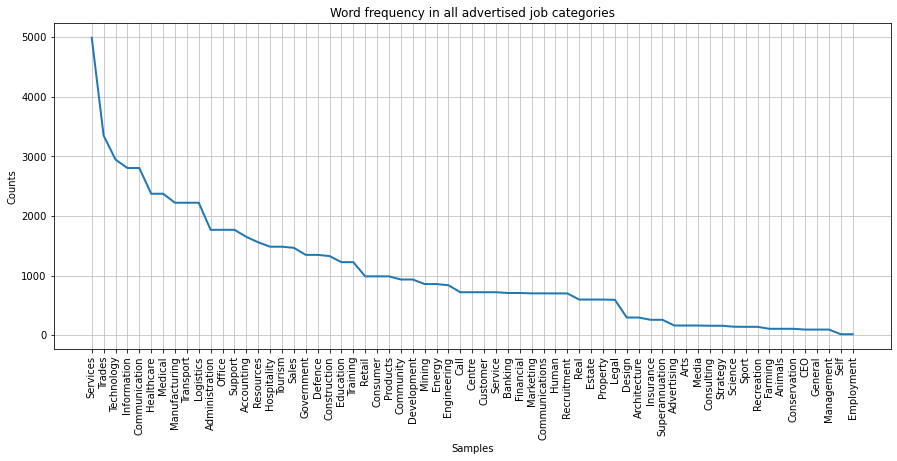

<AxesSubplot:title={'center':'Word frequency in all advertised job categories'}, xlabel='Samples', ylabel='Counts'>

In [121]:
plt.figure(figsize=(15,6))
fdist.plot(title="Word frequency in all advertised job categories")

# 2.0 Data Preprocessing

## 2.1 Tokenize job descriptions

In [122]:
job_cat_desc_df = data[['category','job_description']]

job_cat_desc_df['job_description'] = (job_cat_desc_df['job_description']
                                      .str.replace('â€™', "'")
                                      .str.replace('Â', '')
                                      .str.replace(r'[^\x00-\x7F]', ' ')
)

job_cat_desc_df

,category,job_description
0,Retail & Consumer Products,Have you had 10 years experience in fresh pro...
1,Government & Defence,The Opportunity: The Client Solution Analyst ...
2,Trades & Services,An innovative business development role for a...
3,Trades & Services,About the role: We are seeking an Automotive W...
4,Trades & Services,Early starts and weekend shifts. No experien...
...,...,...
29995,Hospitality & Tourism,Hotel snapshot The Radisson Blu Plaza Sydney ...
29996,CEO & General Management,The Organisation Airservices is a government ...
29997,Accounting,ABOUT THE COMPANY AND ROLE Our client is one o...
29998,Government & Defence,Long term contract for 12 months with possibl...


In [123]:
nlp = spacy.load("en_core_web_lg")
lemmatizer = nlp.get_pipe("lemmatizer")
stemmer = PorterStemmer()

In [124]:
def preprocess_desc(category):
    job_desc_list = job_cat_desc_df[job_cat_desc_df['category']==str(category)]['job_description'].astype('str').tolist()
    doc_bin = DocBin(store_user_data=True)
    
    for doc in nlp.pipe(job_desc_list[:100]): # only retreiving first 100 rows for dev purpose
        doc_bin.add(doc)
    
    return doc_bin

## 2.2 Stemming and Lemmatization

In [125]:
def lemma_stem(doc):
    lemm_stem_list = list()
    for token in doc:
        
        if not token.is_alpha:
            continue
        
        d = {
            'original':token.text,
            'lemmatized':token.lemma_,
            'stemmed':stemmer.stem(token.text)
        }
        
        lemm_stem_list.append(d)
    
    return pd.DataFrame(data=lemm_stem_list)

In [126]:
cat_docBin = preprocess_desc('Trades & Services')

In [127]:
desc_docs_list = list(cat_docBin.get_docs(nlp.vocab))

In [128]:
lemma_stem(desc_docs_list[0])

,original,lemmatized,stemmed
0,An,an,an
1,innovative,innovative,innov
2,business,business,busi
3,development,development,develop
4,role,role,role
...,...,...,...
417,today,today,today
418,No,no,no
419,Recruitment,Recruitment,recruit
420,Agencies,agency,agenc


## 2.3 Retokenize noun phrases

In [28]:
# Retokenize to treat each noun_chunk as a single token,
def retokenize_frequent_NPs(doc):
    
    with doc.retokenize() as retokenizer:
        for chunk in doc.noun_chunks:
            # print(chunk.text + ' ' + str(type(chunk)))
            retokenizer.merge(chunk)
            doc.retokenize().merge(chunk)

### I have a working retokenization function, but I chose not to use it as my pipeline does not require it here

In [29]:
# for doc in desc_docs_list:
#     retokenize_frequent_NPs(doc)

## 2.3 TFIDF

In [145]:
import gensim
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

In [146]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [168]:
testText = job_cat_desc_df.job_description[:50] # only taking a small sample to show this is possible

In [172]:
vocab = [dictionary[i] for i in range(len(dictionary))]

In [173]:
index = list(range(len(BoW_corpus)))

In [170]:
doc_tokenized = list(sent_to_words(testText))
dictionary = Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

In [171]:
tfidf = TfidfModel(BoW_corpus, smartirs='ntc')

2022-04-28 16:38:57,982 - gensim.models.tfidfmodel - INFO - collecting document frequencies
2022-04-28 16:38:57,983 - gensim.models.tfidfmodel - INFO - PROGRESS: processing document #0
2022-04-28 16:38:57,992 - gensim.utils - INFO - TfidfModel lifecycle event {'msg': 'calculated IDF weights for 50 documents and 2823 features (8992 matrix non-zeros)', 'datetime': '2022-04-28T16:38:57.992055', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'initialize'}


In [174]:
df = pd.DataFrame(data=np.zeros((len(BoW_corpus), len(vocab)), dtype=np.float16),
index=index,
columns=vocab)

In [175]:
for idx in index:
    for id, freq in tfidf[BoW_corpus[idx]]:
        df[dictionary[id]][idx] = freq


In [176]:
df.max().sort_values(ascending=True)[:25]

experience      0.011200
to              0.011230
for             0.013954
and             0.014038
on              0.018875
of              0.019852
is              0.023102
with            0.025146
in              0.026245
work            0.026550
will            0.028412
the             0.029785
flight          0.031708
footprint       0.031708
guaranteed      0.031708
herts           0.031708
hull            0.031708
kangaroo        0.031708
know            0.031708
lincolnshire    0.031708
listen          0.031708
main            0.031708
don             0.031708
competitor      0.031708
closing         0.031708
dtype: float16

In [177]:
sort_decr2_topn = lambda row, nlargest=2:sorted(pd.Series(zip(df.columns, row)), key=lambda cv: -cv[1]) [:nlargest]

tmp = df.apply(sort_decr2_topn, axis=1)

tmp.values.tolist()

[[('fresh', 0.407470703125), ('food', 0.333984375)],
 [('powerlink', 0.198974609375), ('requests', 0.198974609375)],
 [('laundry', 0.26123046875), ('adelaide', 0.1741943359375)],
 [('cvs', 0.230712890625), ('unsolicited', 0.230712890625)],
 [('teach', 0.3740234375), ('starts', 0.30810546875)],
 [('blood', 0.40234375), ('quality', 0.1661376953125)],
 [('yates', 0.361083984375), ('marketing', 0.2337646484375)],
 [('families', 0.4619140625), ('community', 0.298095703125)],
 [('health', 0.39794921875), ('austin', 0.37548828125)],
 [('administrator', 0.302978515625), ('system', 0.1905517578125)],
 [('spray', 0.5439453125), ('painter', 0.36279296875)],
 [('coordination', 0.21435546875), ('operations', 0.2060546875)],
 [('excavator', 0.326416015625), ('trucks', 0.326416015625)],
 [('drafting', 0.3623046875), ('oxworks', 0.35205078125)],
 [('project', 0.52587890625), ('projects', 0.231201171875)],
 [('security', 0.24853515625), ('installation', 0.2274169921875)],
 [('rcr', 0.2607421875), ('pla

## 2.4 Other Preprocessing Steps

### After learning more about Spacy, I decided not to adopt the suggested implementation on the project breif. The reason being that I now I understand the power of spacy retaining the original tokenisation, and how any tokenisation processing done on docs is not reversible. I would rather keep the original doc tokenization and adapt my token matching to the required processing steps.

# 3.0 Linguistic Patterns

## 3.1 Years of experience

In [36]:
def experience_matcher(doc):
    """
    Returns the number of years of experience mentioned in the doc (if at all)
    
    """
    
    ent_matcher = Matcher(nlp.vocab)
    dep_matcher = DependencyMatcher(nlp.vocab)
    
    ent_matcher.add("years_exprience_num", [experience_pattern1])
    dep_matcher.add("inexperienced", [experience_pattern2])
    dep_matcher.add("no_experience", [experience_pattern3])
    
    ent_result = ent_matcher(doc)
    dep_result = dep_matcher(doc)
    
    if(ent_result): # if years of experience mentioned
        for match_id, start, end in ent_result:
            return int(doc[start:end]._.numerize())
    elif(dep_result): # if inexperienced
        return 0
    else: # if no mention of experience
        return None

In [37]:
experience_pattern1 = [
    {
        'ENT_TYPE': 'DATE', 
        'LIKE_NUM': True
    }
]

In [38]:
experience_pattern2 = [
    {
        'RIGHT_ID': 'anchor_experience', 
        'RIGHT_ATTRS': {'ORTH': 'experience'}
    },
    {
        'LEFT_ID': 'anchor_experience',
        'REL_OP': '>',
        'RIGHT_ID': 'experience_dep',
        'RIGHT_ATTRS': {'DEP': {'IN':['amod','nummod']}}
    }
]

In [39]:
experience_pattern3 = [
    {
        'RIGHT_ID': 'anchor_experience', 
        'RIGHT_ATTRS': {'ORTH': 'experience'}
    },
    {
        'LEFT_ID': 'anchor_experience',
        'REL_OP': '<',
        'RIGHT_ID': 'experience_dobj_of',
        'RIGHT_ATTRS': {'ORTH': {'IN':['need', 'needing', 'require', 'requiring']}}
    },
    {
        'LEFT_ID': 'experience_dobj_of',
        'REL_OP': '>',
        'RIGHT_ID': 'negation_dep',
        'RIGHT_ATTRS': {'DEP': 'neg'}
    }
]

In [40]:
# testing first pattern
doc1 = nlp("Find me a job for Accountant in Sydney, I have 8 years of experience")
experience_matcher(doc1)

8

In [41]:
# testing second pattern
doc2 = nlp("Find me a job for Accountant in Sydney requiring zero experience.")
experience_matcher(doc2)

0

In [42]:
# testing third pattern
doc3 = nlp("Find me a job for Accountant in Sydney that does not require any experience.")
experience_matcher(doc3)

0

In [43]:
# testing no matching pattern
doc4 = nlp("Find me a job for Accountant in Sydney.")
type(experience_matcher(doc4))

NoneType

## 3.2 Location

In [44]:
def ent_phrase_matcher(doc, ent_pattern, phrase_pattern):
    """
    Returns a matched string in doc via entitity recognition or phrase matching (if at all)
    
    """
    
    ent_matcher = Matcher(nlp.vocab)
    phrase_matcher = PhraseMatcher(nlp.vocab, attr='LOWER')
    
    ent_matcher.add('pattern1', [ent_pattern])
    phrase_matcher.add('pattern2', phrase_pattern)

    
    ent_result = ent_matcher(doc)
    phrase_result = phrase_matcher(doc)
    
    # displacy.render(doc, style="ent")
    if(phrase_result):
        for match_id, start, end in phrase_result:
            # print(phrase_result)
            return doc[start:end]
    elif(ent_result):
        # print(ent_result)
        return doc[ent_result[0][1]:ent_result[-1][-1]]
    
    return None

In [45]:
cities_from_data = [
    loc.strip() for loc in 
    [
        loc for loc in data.city.unique() for loc in re.split(',|&', loc)
    ]
]

In [46]:
location_pattern1 = [{'ENT_TYPE': {'IN': ['LOC', 'GPE']}}]
location_pattern2 = [nlp.make_doc(text) for text in cities_from_data]

In [47]:
# testing first pattern
doc1 = nlp("Find me a job for Accountant in ACT, I have eight years of experience")
displacy.render(doc1, style="ent")
ent_phrase_matcher(doc1, location_pattern1, location_pattern2)

ACT

In [48]:
# testing second pattern
doc1 = nlp("Find me a job for Accountant in Abu Dhabi, I have eight years of experience")
displacy.render(doc1, style="ent")
ent_phrase_matcher(doc1, location_pattern1, location_pattern2)

Abu Dhabi

## 3.4 Company name

In [49]:
company_pattern1 = [{'ENT_TYPE': 'ORG'}]
company_pattern2 = [nlp.make_doc(text) for text in data.company_name.unique()]

In [129]:
# testing first pattern
doc1 = nlp("I have 8 years of experience, find me an accounting job in Microsoft in Sydney.")
displacy.render(doc1, style="ent")
ent_phrase_matcher(doc1, company_pattern1, company_pattern2)

Microsoft

In [130]:
# testing second pattern
doc1 = nlp("find me an accounting job in Sunfresh")
displacy.render(doc1, style="ent")
ent_phrase_matcher(doc1, company_pattern1, company_pattern2)

Sunfresh

## 3.5 Contract hours (full-time, part-time, casual)

In [52]:
def contract_hours_matcher(doc):
    expression = r"(([Ff]ull|[Pp]art)[ -]?([Tt]ime))|([Cc]asual)|([Cc]ontract)"
    for match in re.finditer(expression, doc.text):
        start, end = match.span()
        return doc.char_span(start, end)

In [53]:
# testing no matching pattern
doc1 = nlp("I want a job")
contract_hours_matcher(doc1)

In [54]:
# testing regex pattern
doc1 = nlp("I want a full-time job")
contract_hours_matcher(doc1)

full-time

In [55]:
# testing regex pattern
doc1 = nlp("I want a part time job")
contract_hours_matcher(doc1)

part time

In [56]:
# testing regex pattern
doc1 = nlp("I want a casual job")
contract_hours_matcher(doc1)

casual

## 3.5 Job type

In [57]:
job_type_pattern1 = [
    {
        'RIGHT_ID': 'anchor_jobs', 
        'RIGHT_ATTRS': {'ORTH': {'IN':['jobs','job']}}
    },
    {
        'LEFT_ID': 'anchor_jobs',
        'REL_OP': '>',
        'RIGHT_ID': 'modifier_of_jobs',
        'RIGHT_ATTRS': {
            'ENT_TYPE': {'NOT_IN': ['LOC', 'GPE', 'ORG']},
            'DEP': {'IN': ['compound', 'amod']},
        }
    }
]

job_type_pattern2 = [
    {
        'RIGHT_ID': 'anchor_jobs', 
        'RIGHT_ATTRS': {'ORTH': {'IN':['jobs','job']}}
    },
    {
        'LEFT_ID': 'anchor_jobs',
        'REL_OP': '>',
        'RIGHT_ID': 'prep_of_jobs',
        'RIGHT_ATTRS': {'DEP': 'prep'}
    },
    {
        'LEFT_ID': 'prep_of_jobs',
        'REL_OP': '>',
        'RIGHT_ID': 'pobj_of_jobs',
        'RIGHT_ATTRS': {'ENT_TYPE': {'NOT_IN': ['LOC', 'GPE', 'ORG']},
                        'DEP': 'pobj', 
                        'ORTH': {'NOT_IN': [text for text in cities_from_data]}
                       }
    }
]


In [131]:
def job_type_matcher(doc):
    
    dep_matcher = DependencyMatcher(nlp.vocab)
    dep_matcher.add("job_type", [job_type_pattern1, job_type_pattern2])
    
    dep_result = dep_matcher(doc)
        
    if(dep_result):
        for result in dep_result:
            match_id, token_ids = result
            token = doc[token_ids[-1]]
            contract_hours_token = contract_hours_matcher(doc)
            if(contract_hours_token and token.text in contract_hours_token.text):
                continue
            
            num_compounds = 0
            stack = [child for child in token.lefts]
            while stack:
                child = stack.pop()
                if child.dep_ == 'compound':
                    num_compounds+=1
                    next_child = [c for c in child.lefts]
                    if next_child:
                        stack.append(next_child[0])
            return doc[token.i-num_compounds:token.i+1]
    else:
        return None

In [139]:
# testing first pattern
doc = nlp('Find me accounting jobs in the Sahara Desert.')
job_type_matcher(doc)

accounting

In [138]:
# testing second pattern
doc = nlp('Find me a full-time job in mural painting at Microsoft in Sydney.') 
job_type_matcher(doc)

mural painting

# 4.0 Chatbot Implementation

## 4.1 Getting helper functions ready for chatbot

In [63]:
def parse_search(message):
    """
    Returns a parsed dict of job related entities matched in the string message
    """
    
    doc = nlp(message)
    
    search_ents = { 
        'job_type': None, 
        'location': None, 
        'company_name': None, 
        'contract_hours': None, 
        'years_of_experience': None
    }
    
    
    search_ents['location'] = ent_phrase_matcher(doc, location_pattern1, location_pattern2)
    search_ents['company_name'] = ent_phrase_matcher(doc, company_pattern1, company_pattern2)
    search_ents['contract_hours'] = contract_hours_matcher(doc)
    search_ents['years_of_experience'] = experience_matcher(doc)
    if(job_type_matcher(doc)):
        if search_ents['contract_hours'] and search_ents['contract_hours'].text != job_type_matcher(doc).text:
            search_ents['job_type'] = job_type_matcher(doc)
        else:
            search_ents['job_type'] = job_type_matcher(doc)
    
    return search_ents

In [141]:
message='Find me a full time job as a Client Solution Analyst in Microsoft in Egypt that asks for 5 years of experience.'
parse_search(message)

{'job_type': Client Solution Analyst,
 'location': Egypt,
 'company_name': Microsoft,
 'contract_hours': full time,
 'years_of_experience': 5}

In [65]:
"""
Some data cleaning steps to make life easier. Do not run, the cleaned dataframe is loaded from a pickle to save time
"""

# data.job_type = data.job_type.mask(data.job_type == 'Contract/Temp', 'contract')
# data.job_type = data.job_type.mask(data.job_type == 'Casual/Vacation', 'casual')
# data['years_of_experience'] = data.swifter.apply(lambda x : search_experience(x['job_description']), axis=1)

In [66]:
# import pickle
# file_to_store = open("stored_object.pickle", "wb")
# pickle.dump(data, file_to_store)
# file_to_store.close()

In [67]:
file_to_read = open("stored_object.pickle", "rb")
data = pickle.load(file_to_read)
file_to_read.close()

In [68]:
# change from float to Int64 (int dtype does not allow nulls)
data['years_of_experience'] = data['years_of_experience'].astype('Int64')

In [71]:
def search_experience(desc):
    """
    Crawl through job description to find mentions of experience in a sentence.
    Use spacy to match for years of experience required
    """
    try:
        if type(desc) != str:
            return
        doc = nlp(desc)
        phrase_matcher = PhraseMatcher(nlp.vocab)
        phrases = ['experience', 'experienced']
        patterns = [nlp(text) for text in phrases]
        phrase_matcher.add('exp', None, *patterns)
        for sent in doc.sents:
            for match_id, start, end in phrase_matcher(nlp(sent.text)):
                # print(sent.text)
                if experience_matcher(sent):
                    return experience_matcher(sent)
    except Exception:
        pass

In [72]:
def do_search(search_terms, data_df):
    """
    Uses the parsed search terms to filter the job listings and returns the filtered dataframe
    """
    
    results_df = data_df.copy()
    # print('FILTERS:')
    if(search_terms['location']):
        # print('location= ' + search_terms['location'].text)
        docs = [nlp.make_doc(text) for text in results_df.city]
        bools = [doc.similarity(search_terms['location']) >= 1.0 for doc in docs]
        results_df = results_df[bools]
        
    if(search_terms['company_name']):
        # print('company_name= ' + search_terms['company_name'].text)
        docs = [nlp.make_doc(text) for text in results_df.company_name]
        bools = [doc.similarity(search_terms['company_name']) >= 0.60 for doc in docs]
        results_df = results_df[bools]
        
    if(search_terms['job_type']):
        # print('job_type= ' + search_terms['job_type'].text)
        job_type_docs = [nlp.make_doc(text) for text in results_df.job_type]
        job_cat_docs = [nlp.make_doc(text) for text in results_df.category]
        job_type_bools = [doc.similarity(search_terms['job_type']) >= 0.80 for doc in job_type_docs]
        job_cat_bools = [doc.similarity(search_terms['job_type']) > 0.80 for doc in job_cat_docs]
        
        results_df = results_df[np.logical_or(job_type_bools,job_cat_bools)]
        
    if(search_terms['years_of_experience'] is not None):
        # print('years_of_experience= ' + str(search_terms['years_of_experience']))
        results_df = results_df[(results_df.years_of_experience.isnull())|(results_df.years_of_experience <= search_terms['years_of_experience'])]
        
    if(search_terms['contract_hours']):
        # print('contract_hours= ' + search_terms['contract_hours'].text)
        docs = [nlp.make_doc(text) for text in results_df.job_type]
        bools = [doc.similarity(search_terms['contract_hours']) >= 0.85 for doc in docs]
        results_df = results_df[bools]
    
    return results_df

## 4.2 Chatbot implementation

In [182]:
TOKEN = '5021183430:AAGSQCp66_NEHCC6qTG4yzuYyLu7L7xgfCw'
bot = telegram.Bot(token=TOKEN)

print(bot.get_me())

{'id': 5021183430, 'first_name': 'SeekDoge', 'is_bot': True, 'username': 'SeekDoge_bot', 'can_join_groups': True, 'can_read_all_group_messages': False, 'supports_inline_queries': False}


In [ ]:
def start(update: Update, context: CallbackContext) -> int:
    """Starts the conversation and asks the user about what kind of job they are looking for."""

    update.message.reply_text(
        'Hi! My name is SeekDoge. I am a job search chatbot.\n\n'
        'What do you want me to find?'
    )

def search(update: Update, context: CallbackContext) -> None:
    """Parse the search input from the user"""
    user = update.message.from_user
    message = update.message.text
    search_terms = parse_search(message)
    update.message.reply_text('Thank you, looking into it now...')
    
    message = ''
    for key,val in search_terms.items():
        if val is not None:
            message = message + f"{key}: {val}\n"
    
    update.message.reply_text('I am looking for jobs with these filters:\n\n%s' % message)
    
    for x in range(3):
        time.sleep(0.5)
        update.message.reply_text('...')
        
    results = do_search(search_terms, data) 
    
    if(len(results) == 0):
        update.message.reply_text('I did not find any matches. Please try another search.')
        return None
    
    update.message.reply_text('Here are my top finds')
    for index, row in results.iloc[0:5].iterrows():
        message = (
            f"Job title: {row['job_title']}\n"
            f"Company: {row['company_name']}\n"
            f"Location: {row['city']}\n"
            f"For more information, visit: {row['url']}")
        update.message.reply_text(message)
        time.sleep(0.5)
    
    update.message.reply_text('Hope that helps! Feel free to try another search.')
    
def main() -> None:
    """Run the bot."""
    # Create the Updater and pass it your bot's token.
    updater = Updater(TOKEN)

    # Get the dispatcher to register handlers
    dispatcher = updater.dispatcher

    dispatcher.add_handler(CommandHandler("start", start))
    dispatcher.add_handler(MessageHandler(Filters.text & ~Filters.command, search))
    

    # Start the Bot
    updater.start_polling()

    # Run the bot until you press Ctrl-C or the process receives SIGINT,
    # SIGTERM or SIGABRT. This should be used most of the time, since
    # start_polling() is non-blocking and will stop the bot gracefully.
    updater.idle()


if __name__ == '__main__':
    main()

2022-04-28 17:27:09,100 - apscheduler.scheduler - INFO - Scheduler started
2022-04-28 17:33:41,157 - telegram.vendor.ptb_urllib3.urllib3.connectionpool - WARNING - Retrying (Retry(total=2, connect=None, read=None, redirect=None)) after connection broken by 'NewConnectionError('<telegram.vendor.ptb_urllib3.urllib3.connection.VerifiedHTTPSConnection object at 0x00000207A23BD340>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed')': /bot5021183430:AAGSQCp66_NEHCC6qTG4yzuYyLu7L7xgfCw/getUpdates


# 5.0 Bonus

### Finite State Machine for handling multi-turn dialogue

You can manage a multiturn dialouge system using finite state method. So bascially, when a conversional system has started, the user will parse a query through and in return, a response is selected based on the transition triggered by the query and by the explicit state which stores context information. Finite state machines can be used to keep track of the state of the conversation. In, varying needs ofthe customer and to give information to the customer whenneeded.


To give a very simplistic overview how finite state works. The dialouge is structured and and follows a sequence of predetermined states. So every time a user says something, you will naviagate to the next step based on what he said. Based on the users input (e.g. text for job title), if the state matches the user input then it will go to the next state (i.e. contact hours)


A deterministic finite automation is desribed by 5 elements type 
![/tuples.png](tuples.png)

We are going to look at the following example.

![/example.png](example.png)


- Q = {A, B, C, D} --> refers to all the states (shwn by the circles)
- input = {0, 1} --> refers to the input values 
- F = {D} --> Final state (shown by the double circle
- q = Q x input = Q (transition function) 

The arrow pointing (->) towards A is the starting/initial state. 
Edges: A -> B, B -> A, A -> c, c -> A, C - > D, D -> C, B -> D, D -> B <br> 
There edges are known as transition. Transition simply refer to the change from one state to the next. 

Suppose that the user parses 1 to state A, since the input is 1, State A goes to State B.<br>
Suppose that the input for state B is 0, then the state would transition from State B to State D. <br>
Suppose that the inpit for state C is 1, then the state would transition from State C to State D. <br>
Suppose that the inpit for state C is 0, then the state would transition from State C to State A. <br>
(similar for the rest of the cases)<br>


Example:   

The user wants to search for jobs, the bot is responsible for asking all the other relvant questions: job title, contact hours, location and experience, and the user gives a reply for each

User Input&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;title match. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;hours match &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   location match&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;      experience match   
-----------> job title -----------> contact hours ---------> location -----------> experience -----------> Confirm

Dialouge System Between User and Bot:

**Bot:** What kind of job are you looking for? <br>
**User:** I am looking for an accounting job <br>
**Bot:**  What is your commitment? <br>
**User:** Part-time <br>
**Bot:**  Where are you located? <br>
**User:** I live in Perth <br>
**Bot:**  How many years of experience do you have? <br>
**User:** 10 years <br>

We can utilise finite state machines for multi dialouge conversational system. So when the user inputs a query, the input will check if there are matches for the job title whilst in the title state, then the bot will go to the next state which is contact hours. If the user query matches the contact hours, the bot will move onto the next state and so on. How it works is that, the bot will start the reply with a **hello, how many I help you?**. the bot could potentially just suggest the destination where the user would like to travel.

There are counter measures in place to ensure that if a valid input is not provided by the user, then the state will go to a dead state meaning the user query is rejected. These are done by filters and fallback commands.

Mixed-initiative system ensures the functionality of the multi conversational bot. Mixed-initiative system refers to the fact that the dialouges can either be controlled by the user or the bot. Both the user and the bot have the power to initiate. In terms of the bot, it will ask questions to retrieve the necessary information and the user can answer them. Once the user query parses through the finite state machines, dependent of the states and transitions, the both will respond accordingly. In terms of a job search bot, the state will store the context of the conversation and the transition is the Intent. This is how you will ensure a dialouge manaegment system.
